# Bernstein-Vazirani

In [2]:
# initialization
import matplotlib.pyplot as plt
import numpy as np

# importing Qiskit
from qiskit import IBMQ, Aer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile, assemble

# import basic plot tools
from qiskit.visualization import plot_histogram

In [3]:
n = 3 # number of qubits used to represent s
s = '011'   # the hidden binary string

In [4]:
# We need a circuit with n qubits, plus one auxiliary qubit
# Also need n classical bits to write the output to
bv_circuit = QuantumCircuit(n+1, n)

# put auxiliary in state |->
bv_circuit.h(n)
bv_circuit.z(n)

# Apply Hadamard gates before querying the oracle
for i in range(n):
    bv_circuit.h(i)
    
# Apply barrier 
bv_circuit.barrier()

# Apply the inner-product oracle
s = s[::-1] # reverse s to fit qiskit's qubit ordering
for q in range(n):
    if s[q] == '0':
        bv_circuit.i(q)
    else:
        bv_circuit.cx(q, n)
        
# Apply barrier 
bv_circuit.barrier()

#Apply Hadamard gates after querying the oracle
for i in range(n):
    bv_circuit.h(i)

# Measurement
for i in range(n):
    bv_circuit.measure(i, i)

bv_circuit.draw()

┌───┐      ░                 ░ ┌───┐┌─┐      
q_0: ┤ H ├──────░───■─────────────░─┤ H ├┤M├──────
     ├───┤      ░   │             ░ ├───┤└╥┘┌─┐   
q_1: ┤ H ├──────░───┼─────────■───░─┤ H ├─╫─┤M├───
     ├───┤      ░   │  ┌───┐  │   ░ ├───┤ ║ └╥┘┌─┐
q_2: ┤ H ├──────░───┼──┤ I ├──┼───░─┤ H ├─╫──╫─┤M├
     ├───┤┌───┐ ░ ┌─┴─┐└───┘┌─┴─┐ ░ └───┘ ║  ║ └╥┘
q_3: ┤ H ├┤ Z ├─░─┤ X ├─────┤ X ├─░───────╫──╫──╫─
     └───┘└───┘ ░ └───┘     └───┘ ░       ║  ║  ║ 
c: 3/═════════════════════════════════════╩══╩══╩═
                                          0  1  2

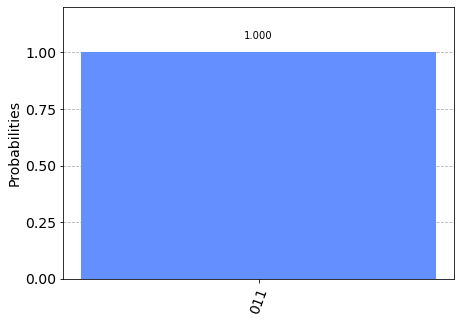

In [5]:
# use local simulator
aer_sim = Aer.get_backend('aer_simulator')
shots = 1024
qobj = assemble(bv_circuit)
results = aer_sim.run(qobj).result()
answer = results.get_counts()

plot_histogram(answer)

In [6]:
# Load our saved IBMQ accounts and get the least busy backend device with less than or equal to 5 qubits
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
provider.backends()
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits <= 5 and
                                   x.configuration().n_qubits >= 2 and
                                   not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend)

least busy backend:  ibmq_santiago


In [7]:
# Run our circuit on the least busy backend. Monitor the execution of the job in the queue
from qiskit.tools.monitor import job_monitor

shots = 1024
transpiled_bv_circuit = transpile(bv_circuit, backend)
job = backend.run(transpiled_bv_circuit, shots=shots)

job_monitor(job, interval=2)

Job Status: job has successfully run


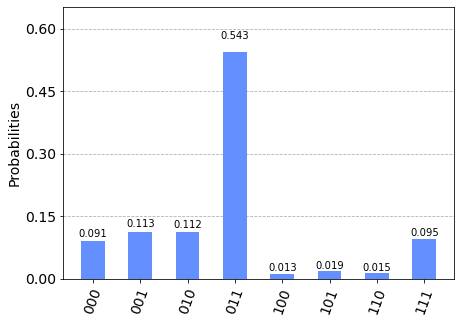

In [8]:
# Get the results from the computation
results = job.result()
answer = results.get_counts()

plot_histogram(answer)